In [1]:
import mxnet as mx

# Debugging MXNet Gluon
## And other performance tricks

In [2]:
import multiprocessing
import time
 
import mxnet as mx
from mxnet import gluon, nd, autograd
import numpy as np
import random 
import mxboard as mxb

from skimage.transform import resize

In [3]:
mx.random.seed(42)
np.random.seed(42)
random.seed(42)

## 1) Visualizing Network

In [4]:
shape = (1, 3, 224, 224)

In [5]:
alexnet = gluon.model_zoo.vision.alexnet()
alexnet.initialize()

### Gluon layers description

In [6]:
print(alexnet)

AlexNet(
  (features): HybridSequential(
    (0): Conv2D(None -> 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (2): Conv2D(None -> 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (4): Conv2D(None -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2D(None -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Conv2D(None -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (8): Flatten
    (9): Dense(None -> 4096, Activation(relu))
    (10): Dropout(p = 0.5, axes=())
    (11): Dense(None -> 4096, Activation(relu))
    (12): Dropout(p = 0.5, axes=())
  )
  (output): Dense(None -> 1000, linear)
)


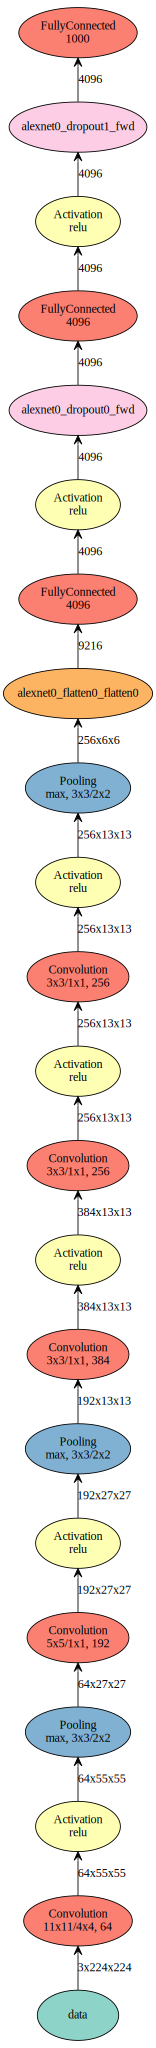

In [7]:
mx.viz.plot_network(
    alexnet(mx.sym.var('data')), 
    shape={'data':shape},
    node_attrs={"shape":"oval","fixedsize":"false"}
)

In [8]:
mx.viz.print_summary(
    alexnet(mx.sym.var('data')), 
    shape={'data':shape}
)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                          3x224x224               0                                           
________________________________________________________________________________________________________________________
alexnet0_conv0_fwd(Convolution)                     64x55x55                23296       data                            
________________________________________________________________________________________________________________________
alexnet0_conv0_relu_fwd(Activation)                 64x55x55                0           alexnet0_conv0_fwd              
________________________________________________________________________________________________________________________
alexnet0_pool0_fwd(Pooling)     

In [9]:
!rm -rf logs && mkdir logs

In [10]:
sw = mxb.SummaryWriter(logdir='logs', flush_secs=3)

In [11]:
alexnet.hybridize()
out = alexnet(mx.nd.ones(shape))

In [12]:
sw.add_graph(alexnet)

## 2) Performance tricks

## Model

We get a relatively simple and common model architecture from the model the zoo, ResNet50 architecture

In [13]:
ctx = mx.gpu()
net = gluon.model_zoo.vision.resnet50_v2(pretrained=False, ctx=ctx)
net.initialize(mx.init.Xavier(magnitude=2.3), ctx=ctx)

## Data

In [14]:
BATCH_SIZE = 48

In [15]:
def transform(x, y):
    x = resize(x.asnumpy(), (224, 224), anti_aliasing=False, mode='constant')
    x = x.transpose((2, 0, 1)).astype('float32')
    return x, y
dataset_train = gluon.data.vision.CIFAR10(train=True, transform=transform)

In [16]:
dataloader_train = gluon.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False, last_batch="discard")

## Loss

In [17]:
loss_fn = gluon.loss.SoftmaxCELoss()

## Metric

In [18]:
accuracy = mx.metric.Accuracy()

## Optimizer

In [19]:
trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.001, 'momentum':0.9, 'wd':0.00001})

## Training Loop

# Performance optimization

### 1) Naive Attempt

In [20]:
%%time

epoch = 1
print_n = 5

for e in range(epoch):
    tick = time.time()
    for i, (data, label) in enumerate(dataloader_train):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        if i == 0:
            tick_0 = time.time()
            
        # Forward pass and loss computation
        with autograd.record():
            output = net(data)
            loss = loss_fn(output, label)
        
        # Compute gradient
        loss.backward()
        
        # Update network weights
        trainer.step(data.shape[0])
        
        # Update metric
        accuracy.update(label, output)
        
        # Print batch metrics
        if i % print_n == 0 and i > 0:
            sw.add_scalar(tag='Accuracy', value={'naive':accuracy.get()[1]}, global_step=i-print_n)
            sw.add_scalar(tag='Speed', value={'naive':data.shape[0]*(print_n)/(time.time()-tick)}, global_step=i-print_n)
            print('Batch [{}], Accuracy {:.4f}, Samples/sec: {:.4f}'.format(
                i, accuracy.get()[1], data.shape[0]*(print_n)/(time.time()-tick))
            )
            tick = time.time()
        
        if i == 200:
            break
            
    print('Epoch [{}], Accuracy {:.4f}'.format(e, accuracy.get()[1]))
    print('~Samples/Sec {:.4f}'.format(data.shape[0]*(i+1)/(time.time()-tick_0)))
    accuracy.reset()
    sw.flush()

Batch [5], Accuracy 0.0000, Samples/sec: 66.8637
Batch [10], Accuracy 0.0530, Samples/sec: 150.6258
Batch [15], Accuracy 0.0768, Samples/sec: 150.6121
Batch [20], Accuracy 0.0923, Samples/sec: 150.7200
Batch [25], Accuracy 0.0978, Samples/sec: 150.7461
Batch [30], Accuracy 0.1129, Samples/sec: 150.6971
Batch [35], Accuracy 0.1192, Samples/sec: 150.5710
Batch [40], Accuracy 0.1235, Samples/sec: 150.6267
Batch [45], Accuracy 0.1277, Samples/sec: 150.0848
Batch [50], Accuracy 0.1291, Samples/sec: 150.6822
Batch [55], Accuracy 0.1298, Samples/sec: 150.6866
Batch [60], Accuracy 0.1376, Samples/sec: 150.3928
Batch [65], Accuracy 0.1449, Samples/sec: 150.4270
Batch [70], Accuracy 0.1508, Samples/sec: 150.6959
Batch [75], Accuracy 0.1546, Samples/sec: 150.4277
Batch [80], Accuracy 0.1584, Samples/sec: 150.2160
Batch [85], Accuracy 0.1609, Samples/sec: 148.7087
Batch [90], Accuracy 0.1655, Samples/sec: 148.5029
Batch [95], Accuracy 0.1680, Samples/sec: 150.0329
Batch [100], Accuracy 0.1702, Sam

Notice how we are I/O constrained, very low GPU util, drops in GPU util and high CPU utilization

### 2) Using multiprocessing workers

In [21]:
dataloader_train = gluon.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False, last_batch="discard", 
                                         num_workers=multiprocessing.cpu_count()-3)

In [22]:
net.initialize(mx.init.Xavier(magnitude=2.3), ctx=ctx, force_reinit=True)

In [23]:
%%time

epoch = 1
print_n = 5

for e in range(epoch):
    tick = time.time()
    for i, (data, label) in enumerate(dataloader_train):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        if i == 0:
            tick_0 = time.time()
        
        # Forward pass and loss computation
        with autograd.record():
            output = net(data)
            loss = loss_fn(output, label)
        
        # Compute gradient
        loss.backward()
        
        # Update network weights
        trainer.step(data.shape[0])
        
        # Update metric
        accuracy.update(label, output)
        
        # Print batch metrics
        if i % print_n == 0 and i > 0:
            sw.add_scalar(tag='Accuracy', value={'multi':accuracy.get()[1]}, global_step=i-print_n)
            sw.add_scalar(tag='Speed', value={'multi':data.shape[0]*(print_n)/(time.time()-tick)}, global_step=i-print_n)
            print('Batch [{}], Accuracy {:.4f}, Samples/sec: {:.4f}'.format(
                i, accuracy.get()[1], data.shape[0]*(print_n)/(time.time()-tick))
            )
            tick = time.time()
        
        if i == 200:
            break
            
    print('Epoch [{}], Accuracy {:.4f}'.format(e, accuracy.get()[1]))
    print('~Samples/Sec {:.4f}'.format(data.shape[0]*(i+1)/(time.time()-tick_0)))
    accuracy.reset()
    sw.flush()

Batch [5], Accuracy 0.0000, Samples/sec: 59.0021
Batch [10], Accuracy 0.0284, Samples/sec: 318.1898
Batch [15], Accuracy 0.0469, Samples/sec: 316.9047
Batch [20], Accuracy 0.0665, Samples/sec: 316.9373
Batch [25], Accuracy 0.0817, Samples/sec: 317.1896
Batch [30], Accuracy 0.0988, Samples/sec: 316.3494
Batch [35], Accuracy 0.1117, Samples/sec: 316.0719
Batch [40], Accuracy 0.1214, Samples/sec: 318.6419
Batch [45], Accuracy 0.1227, Samples/sec: 315.4756
Batch [50], Accuracy 0.1230, Samples/sec: 319.5256
Batch [55], Accuracy 0.1243, Samples/sec: 316.9392
Batch [60], Accuracy 0.1305, Samples/sec: 316.4844
Batch [65], Accuracy 0.1364, Samples/sec: 317.9930
Batch [70], Accuracy 0.1408, Samples/sec: 319.0443
Batch [75], Accuracy 0.1467, Samples/sec: 318.3508
Batch [80], Accuracy 0.1499, Samples/sec: 318.9969
Batch [85], Accuracy 0.1526, Samples/sec: 317.5325
Batch [90], Accuracy 0.1580, Samples/sec: 317.5564
Batch [95], Accuracy 0.1608, Samples/sec: 319.4909
Batch [100], Accuracy 0.1625, Sam

We notice now that CPU utilization seems to be less than 100% so data fetching and resizing is no more the bottleneck

### 3) Hybridization

In [24]:
net.initialize(mx.init.Xavier(magnitude=2.3), ctx=ctx, force_reinit=True)
net.hybridize(static_alloc=True, static_shape=True)
out = net(mx.nd.ones(shape, ctx))

In [25]:
%%time

epoch = 1
print_n = 5

for e in range(epoch):
    tick = time.time()
    for i, (data, label) in enumerate(dataloader_train):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        if i == 0:
            tick_0 = time.time()
            
        # Forward pass and loss computation
        with autograd.record():
            output = net(data)
            loss = loss_fn(output, label)
        
        # Compute gradient
        loss.backward()
        
        # Update network weights
        trainer.step(data.shape[0])
        
        # Update metric
        accuracy.update(label, output)
        
        # Print batch metrics
        if i % print_n == 0 and i > 0:
            sw.add_scalar(tag='Accuracy', value={'hybrid':accuracy.get()[1]}, global_step=i-print_n)
            sw.add_scalar(tag='Speed', value={'hybrid':data.shape[0]*(print_n)/(time.time()-tick)}, global_step=i-print_n)
            print('Batch [{}], Accuracy {:.4f}, Samples/sec: {:.4f}'.format(
                i, accuracy.get()[1], data.shape[0]*(print_n)/(time.time()-tick))
            )
            tick = time.time()
        
        if i == 200:
            break
            
    print('Epoch [{}], Accuracy {:.4f}'.format(e, accuracy.get()[1]))
    print('~Samples/Sec {:.4f}'.format(data.shape[0]*(i+1)/(time.time()-tick_0)))
    accuracy.reset()
    sw.flush()

Batch [5], Accuracy 0.0000, Samples/sec: 63.1960
Batch [10], Accuracy 0.0379, Samples/sec: 336.8077
Batch [15], Accuracy 0.0547, Samples/sec: 331.5346
Batch [20], Accuracy 0.0823, Samples/sec: 336.5567
Batch [25], Accuracy 0.0889, Samples/sec: 336.9529
Batch [30], Accuracy 0.0981, Samples/sec: 335.1901
Batch [35], Accuracy 0.1059, Samples/sec: 333.2704
Batch [40], Accuracy 0.1148, Samples/sec: 337.6234
Batch [45], Accuracy 0.1223, Samples/sec: 333.0279
Batch [50], Accuracy 0.1258, Samples/sec: 333.1187
Batch [55], Accuracy 0.1246, Samples/sec: 335.7965
Batch [60], Accuracy 0.1301, Samples/sec: 333.0308
Batch [65], Accuracy 0.1360, Samples/sec: 334.1175
Batch [70], Accuracy 0.1417, Samples/sec: 335.5542
Batch [75], Accuracy 0.1483, Samples/sec: 334.4632
Batch [80], Accuracy 0.1515, Samples/sec: 335.7788
Batch [85], Accuracy 0.1553, Samples/sec: 336.3428
Batch [90], Accuracy 0.1596, Samples/sec: 334.9039
Batch [95], Accuracy 0.1617, Samples/sec: 336.1273
Batch [100], Accuracy 0.1636, Sam

### 4) Tweaking hyper-parameters

In [26]:
BATCH_SIZE = 96
dataloader_train = gluon.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False, last_batch="discard", num_workers=multiprocessing.cpu_count()-3)

In [27]:
net.initialize(mx.init.Xavier(magnitude=2.3), ctx=ctx, force_reinit=True)
trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.001*2, 'momentum':0.9, 'wd':0.00001})

In [28]:
%%time

epoch = 1
print_n = 5

for e in range(epoch):
    tick = time.time()
    for i, (data, label) in enumerate(dataloader_train):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        if i == 0:
            tick_0 = time.time()
            
        # Forward pass and loss computation
        with autograd.record():
            output = net(data)
            loss = loss_fn(output, label)
        
        # Compute gradient
        loss.backward()
        
        # Update network weights
        trainer.step(data.shape[0])
        
        # Update metric
        accuracy.update(label, output)
        
        # Print batch metrics
        if i % print_n == 0 and i > 0:
            sw.add_scalar(tag='Accuracy', value={'hybrid':accuracy.get()[1]}, global_step=i-print_n)
            sw.add_scalar(tag='Speed', value={'hybrid':data.shape[0]*(print_n)/(time.time()-tick)}, global_step=i-print_n)
            print('Batch [{}], Accuracy {:.4f}, Samples/sec: {:.4f}'.format(
                i, accuracy.get()[1], data.shape[0]*(print_n)/(time.time()-tick))
            )
            tick = time.time()
        
        if i == 100:
            break
            
    print('Epoch [{}], Accuracy {:.4f}'.format(e, accuracy.get()[1]))
    print('~Samples/Sec {:.4f}'.format(data.shape[0]*(i+1)/(time.time()-tick_0)))
    accuracy.reset()
    sw.flush()

Batch [5], Accuracy 0.0052, Samples/sec: 66.9523
Batch [10], Accuracy 0.0625, Samples/sec: 353.6753
Batch [15], Accuracy 0.0885, Samples/sec: 354.3142
Batch [20], Accuracy 0.1081, Samples/sec: 353.1239
Batch [25], Accuracy 0.1158, Samples/sec: 353.4846
Batch [30], Accuracy 0.1200, Samples/sec: 352.3092
Batch [35], Accuracy 0.1279, Samples/sec: 354.1068
Batch [40], Accuracy 0.1415, Samples/sec: 352.3975
Batch [45], Accuracy 0.1495, Samples/sec: 353.9529
Batch [50], Accuracy 0.1532, Samples/sec: 353.9335
Batch [55], Accuracy 0.1620, Samples/sec: 353.5304
Batch [60], Accuracy 0.1696, Samples/sec: 352.0163
Batch [65], Accuracy 0.1765, Samples/sec: 353.4798
Batch [70], Accuracy 0.1805, Samples/sec: 353.3853
Batch [75], Accuracy 0.1867, Samples/sec: 352.5141
Batch [80], Accuracy 0.1897, Samples/sec: 351.5919
Batch [85], Accuracy 0.1940, Samples/sec: 351.4152
Batch [90], Accuracy 0.1976, Samples/sec: 352.2999
Batch [95], Accuracy 0.2016, Samples/sec: 353.5182
Batch [100], Accuracy 0.2067, Sam

### 5) Synchronization calls

In [29]:
ctx = mx.gpu(1)
net = gluon.model_zoo.vision.resnet50_v2(pretrained=False, ctx=ctx)
net.initialize(mx.init.Xavier(magnitude=2.3), ctx=ctx)
net.hybridize(static_alloc=True, static_shape=True)
out = net(mx.nd.ones(shape, ctx))
trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.001*2, 'momentum':0.9, 'wd':0.00001})
accuracy = mx.metric.Accuracy()

In [30]:
%%time

epoch = 1
print_n_sync = 2
print_n = 6
tick_0 = time.time()

for e in range(epoch):
    tick = time.time()
    for i, (data, label) in enumerate(dataloader_train):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        if i == 0:
            tick_0 = time.time()

        # Update metric
        if i % print_n_sync == 0 and i > 0:
            accuracy.update(old_label, output)
            
        old_label = label
        
        # Print batch metrics            
        if i % print_n == 0 and i > 0:
            sw.add_scalar(tag='Accuracy', value={'hybrid_sync':accuracy.get()[1]}, global_step=i-print_n)
            sw.add_scalar(tag='Speed', value={'hybrid_sync':data.shape[0]*(print_n)/(time.time()-tick)}, global_step=i-print_n)

            print('Batch [{}], Accuracy {:.4f}, Samples/sec: {:.4f}'.format(
                i, accuracy.get()[1], data.shape[0]*(print_n)/(time.time()-tick))
            )
            tick = time.time()
            
        # Forward pass and loss computation
        with autograd.record():
            output = net(data)
            loss = loss_fn(output, label)
            
        # Compute gradient
        loss.backward()
        
        # Update network weights
        trainer.step(data.shape[0])
        
        
        if i == 100:
            break
    print('Epoch [{}], Accuracy {:.4f}'.format(e, accuracy.get()[1]))
    print('~Samples/Sec {:.4f}'.format(data.shape[0]*(i+1)/(time.time()-tick_0)))
    accuracy.reset()
    sw.flush()

Batch [6], Accuracy 0.0347, Samples/sec: 78.3489
Batch [12], Accuracy 0.0816, Samples/sec: 358.9973
Batch [18], Accuracy 0.1088, Samples/sec: 359.1010
Batch [24], Accuracy 0.1311, Samples/sec: 358.9790
Batch [30], Accuracy 0.1403, Samples/sec: 360.8360
Batch [36], Accuracy 0.1510, Samples/sec: 360.0456
Batch [42], Accuracy 0.1597, Samples/sec: 359.4274
Batch [48], Accuracy 0.1641, Samples/sec: 360.5154
Batch [54], Accuracy 0.1736, Samples/sec: 361.4277
Batch [60], Accuracy 0.1865, Samples/sec: 361.3078
Batch [66], Accuracy 0.1932, Samples/sec: 360.5078
Batch [72], Accuracy 0.1962, Samples/sec: 358.7389
Batch [78], Accuracy 0.2046, Samples/sec: 360.3182
Batch [84], Accuracy 0.2078, Samples/sec: 360.5506
Batch [90], Accuracy 0.2111, Samples/sec: 361.0153
Batch [96], Accuracy 0.2133, Samples/sec: 359.4800
Epoch [0], Accuracy 0.2158
~Samples/Sec 343.5016
CPU times: user 22 s, sys: 14.7 s, total: 36.7 s
Wall time: 32.5 s


## 6) Float16

In [31]:
net.initialize(mx.init.Xavier(magnitude=2.3), ctx=ctx, force_reinit=True)
net.cast('float16')

In [32]:
trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.001*2, 'momentum':0.9, 'wd':0.00001, 'multi_precision':True})
accuracy.reset()

In [33]:
%%time

epoch = 1
print_n_sync = 2
print_n = 5
tick_0 = time.time()

for e in range(epoch):
    tick = time.time()
    for i, (data, label) in enumerate(dataloader_train):
        data = data.as_in_context(ctx).astype('float16')
        label = label.as_in_context(ctx).astype('float16')

        # Update metric
        if i % print_n_sync == 0 and i > 0:
            accuracy.update(old_label, output)
        
        old_label = label
        
        if i == 0:
            tick_0 = time.time()
            
        # Print batch metrics            
        if i % print_n == 0 and i > 0:
            sw.add_scalar(tag='Accuracy', value={'float_16':accuracy.get()[1]}, global_step=i-print_n)
            sw.add_scalar(tag='Speed', value={'float_16':data.shape[0]*(print_n)/(time.time()-tick)}, global_step=i-print_n)

            print('Batch [{}], Accuracy {:.4f}, Samples/sec: {:.4f}'.format(
                i, accuracy.get()[1], data.shape[0]*(print_n)/(time.time()-tick))
            )
            tick = time.time()
            
        # Forward pass and loss computation
        with autograd.record():
            output = net(data)
            loss = loss_fn(output, label)
            
        # Compute gradient
        loss.backward()
        
        # Update network weights
        trainer.step(data.shape[0])
        
        # Update metric
        if i % print_n_sync == 0:
            accuracy.update(label, output)

        
        if i == 100:
            break
    print('Epoch [{}], Accuracy {:.4f}'.format(e, accuracy.get()[1]))
    print('~Samples/Sec {:.4f}'.format(data.shape[0]*(i+1)/(time.time()-tick_0)))
    accuracy.reset()


Batch [5], Accuracy 0.0000, Samples/sec: 73.5266
Batch [10], Accuracy 0.0396, Samples/sec: 739.7862
Batch [15], Accuracy 0.0750, Samples/sec: 750.0259
Batch [20], Accuracy 0.0953, Samples/sec: 717.8348
Batch [25], Accuracy 0.1163, Samples/sec: 743.4844
Batch [30], Accuracy 0.1187, Samples/sec: 737.8257
Batch [35], Accuracy 0.1235, Samples/sec: 746.4267
Batch [40], Accuracy 0.1378, Samples/sec: 736.4721
Batch [45], Accuracy 0.1465, Samples/sec: 746.2533
Batch [50], Accuracy 0.1500, Samples/sec: 724.8396
Batch [55], Accuracy 0.1538, Samples/sec: 753.1383
Batch [60], Accuracy 0.1630, Samples/sec: 723.8672
Batch [65], Accuracy 0.1692, Samples/sec: 743.5487
Batch [70], Accuracy 0.1763, Samples/sec: 722.6098
Batch [75], Accuracy 0.1793, Samples/sec: 745.6546
Batch [80], Accuracy 0.1855, Samples/sec: 736.2004
Batch [85], Accuracy 0.1884, Samples/sec: 747.7897
Batch [90], Accuracy 0.1918, Samples/sec: 725.2710
Batch [95], Accuracy 0.1948, Samples/sec: 743.6174
Batch [100], Accuracy 0.1992, Sam

In [34]:
time.sleep(3)
sw.flush()

### 7) Good datapoint: Testing theoritical maximum speed without I/O

In [35]:
batches = 10
tick_0 = time.time()
data = mx.nd.ones((BATCH_SIZE,3,224,224), ctx=ctx, dtype='float16')
for i in range(batches):
    with autograd.record():
        out = net(data)
    out.backward()
    trainer.step(data.shape[0])
out.asnumpy()
mx.nd.waitall()
print('Max Sample Speed {:.4f}'.format(batches*BATCH_SIZE/(time.time()-tick_0)))

Max Sample Speed 797.1622


# Env Variables

https://mxnet.incubator.apache.org/faq/env_var.html

## Profiler

In [36]:
from mxnet import profiler
profiler.set_config(profile_all=True, aggregate_stats=True, filename='profile_output.json')

ctx = mx.gpu()
net = gluon.model_zoo.vision.resnet50_v2(pretrained=False, ctx=ctx)
net.initialize(mx.init.Xavier(magnitude=2.3), ctx=ctx)
trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.001, 'momentum':0.9, 'wd':0.00001})

In [37]:
batches = 1
BATCH_SIZE = 32
tick_0 = time.time()
data = mx.nd.ones((BATCH_SIZE,3,224,224), ctx=ctx, dtype='float32')
profiler.set_state('run')
for i in range(batches):
    with autograd.record():
        out = net(data)
    #out.backward()
    #trainer.step(data.shape[0])
out.asnumpy()
mx.nd.waitall()
profiler.set_state('stop')

In [38]:
profiler.dump()

In [40]:
print(profiler.dumps())


Profile Statistics.
	Note that counter items are counter values and not time units.
Device Storage
Name                          Total Count        Time (ms)    Min Time (ms)    Max Time (ms)    Avg Time (ms)
----                          -----------        ---------    -------------    -------------    -------------
Memory: gpu/0                         722     2642262.5000        8388.6084     2654455.2500     1323033.3750
Memory: cpu/0                         474           0.0000           0.0000       18984.9609        9492.4805

MXNET_C_API
Name                          Total Count        Time (ms)    Min Time (ms)    Max Time (ms)    Avg Time (ms)
----                          -----------        ---------    -------------    -------------    -------------
MXAutogradMarkVariables               133           0.7330           0.0040           0.0080           0.0055
MXNDArrayFree                         411           0.8010           0.0000           0.1230           0.0019
MXNDArr